# Multimodal Sentiment Analysis

## 📦 1. Importing Required Libraries

We begin by importing essential libraries and utility modules used throughout this project:

- **NumPy** for numerical and matrix operations.
- **Matplotlib (Pyplot)** for visualizing model performance, attention weights, or embeddings.
- **`script.py` as `util`**, a custom module containing reusable functions or model components (e.g., preprocessing, layers, or metrics).
- **Pickle** for serializing and loading intermediate data objects, such as preprocessed features or model weights.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import script as util
import pickle

Error reading pickle file: [Errno 2] No such file or directory: './unaligned_50.pkl'
Failed to load dataset.


## 📂 2. Loading the Preprocessed Multimodal Dataset

We use Python’s `pickle` module to load the aligned dataset from disk.

The file is expected to contain synchronized representations for **text, audio, and video modalities**.

Note: Ensure the file `aligned_50.pkl` exists at the specified path or is mounted correctly in the runtime environment.
      If not present download from [here]().

In [2]:
## Path to Dataset
Data_Path = './aligned_50.pkl'

In [3]:
try:
  with open(Data_Path, 'rb') as f:
    data = pickle.load(f)
except Exception as e:
  print(f"Error loading pickle file: {e}")

## 📊 3. Inspecting the Dataset

We utilize custom inspection functions from `script.py` to explore the structure and contents of our multimodal dataset. This step helps understand feature dimensions of all modalities (text, audio, vision) and labels.

In [4]:
try:
    Dataset_dict = util.inspect_dataset(data)
except SystemExit as e:
    print(f"SystemExit with code: {e.code}")

Top-Level Keys in Dataset: ['train', 'valid', 'test']

Field: train
Number of sub-fields in Field: 9
Example sub-fields: ['raw_text', 'audio', 'vision', 'id', 'text', 'text_bert', 'annotations', 'classification_labels', 'regression_labels']

	Sub-field: raw_text
	Type of data: <class 'numpy.ndarray'>
	Shape of Data: (1284,)

	Sub-field: audio
	Type of data: <class 'numpy.ndarray'>
	Shape of Data: (1284, 50, 5)

	Sub-field: vision
	Type of data: <class 'numpy.ndarray'>
	Shape of Data: (1284, 50, 20)

	Sub-field: id
	Type of data: <class 'list'>
	Shape of Data: 1284

	Sub-field: text
	Type of data: <class 'numpy.ndarray'>
	Shape of Data: (1284, 50, 768)

	Sub-field: text_bert
	Type of data: <class 'numpy.ndarray'>
	Shape of Data: (1284, 3, 50)

	Sub-field: annotations
	Type of data: <class 'list'>
	Shape of Data: 1284

	Sub-field: classification_labels
	Type of data: <class 'numpy.ndarray'>
	Shape of Data: (1284,)

	Sub-field: regression_labels
	Type of data: <class 'numpy.ndarray'>
	Sha

In [5]:
print("Dataset_dict:")

print(f"\tKeys: {Dataset_dict.keys()}")
print(f"\t\tSub-keys in Train: {Dataset_dict['train'].keys()}")

print(f"\t\t\tLength of Train id: {len(Dataset_dict['train']['id'])}")
print(f"\t\t\tShape of Train audio: {Dataset_dict['train']['audio'].shape}")
print(f"\t\t\tShape of Train vision: {Dataset_dict['train']['vision'].shape}")
print(f"\t\t\tShape of Train text: {Dataset_dict['train']['text'].shape}")
print(f"\t\t\tShape of Train classification_labels: {Dataset_dict['train']['classification_labels'].shape}")
print(f"\t\t\tShape of Train regression_labels: {Dataset_dict['train']['regression_labels'].shape}")

Dataset_dict:
	Keys: dict_keys(['train', 'valid', 'test'])
		Sub-keys in Train: dict_keys(['audio', 'vision', 'id', 'text', 'classification_labels', 'regression_labels'])
			Length of Train id: 1284
			Shape of Train audio: (1284, 50, 5)
			Shape of Train vision: (1284, 50, 20)
			Shape of Train text: (1284, 50, 768)
			Shape of Train classification_labels: (1284,)
			Shape of Train regression_labels: (1284,)



## 📐 4. Hyperparameter Setup
In this section, we import the necessary libraries for dataset handling, model construction, and define all key hyperparameters used throughout the workflow.

Below, we also summarize the main hyperparameters as described in the DISRFN paper.
- `BATCH_SIZE`: Mini-batch size for training  
- `DROP`: Dropout rate used in regularization  
- `HID`, `P_HID`: Hidden dimensions for network layers  
- `MAX_EPOCH`: Number of training epochs  
- `LEARNING_RATE`: Learning rate for the optimizer  
- `VISUAL_DIM`, `ACOUSTIC_DIM`, `LANGUAGE_DIM`: Input dimensions for vision, audio, and text features  
- `OUTPUT_DIM`: Number of output classes (e.g., sentiment categories)

These settings are crucial for reproducibility and model performance tuning

In [6]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, Subset
import torch.optim as optim
import matplotlib.pyplot as plt
import time

In [7]:
# Initialize GPU device (if available)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Device currently in Use:{device}")

Device currently in Use:cpu


In [8]:
## These Constants will be used later on various steps
## I am defining all of them here
## These are mainly parameters and hyperparameters

BATCH_SIZE = 16

DROP = 0.4
HID = 256
P_HID = 64

MAX_EPOCH = 15
LEARNING_RATE = 0.0001

VISUAL_DIM = 20
ACOUSTIC_DIM = 5
LANGUAGE_DIM = 768
OUTPUT_DIM = 3

## 🛠️ 5. Custom PyTorch Dataset & DataLoader Pipeline

We define a `MyDataset` class to convert raw multimodal data (audio, vision, text, labels) into PyTorch tensors and organize them into train, validation, and test splits.

The `create_dataloader` function wraps each split in a DataLoader, enabling efficient batching, shuffling, and easy batch size adjustment.

This setup ensures data is ready for scalable and reproducible multimodal experiments.


In [9]:
class MyDataset(Dataset):
    def __init__(self, dataset: dict):
        """
        Initializes the dataset with splits: train, valid, and test.
        Expects dataset to be a dict with keys: 'train', 'valid', 'test'.
        Each split should have sub-keys 'audio', 'vision', 'text',
        'classification_labels', and optionally 'regression_labels'.
        """
        self.dataset = dataset

        self.train_data = []
        self.valid_data = []
        self.test_data = []

        self._process_data()

    def _process_data(self):
        """
        Process and convert each sample in the dataset to tensors.
        """
        for split in ['train', 'valid', 'test']:
            if split not in self.dataset:
                raise ValueError(f"Expected split '{split}' not found in dataset keys {list(self.dataset.keys())}")

            split_data = self.dataset[split]
            split_list = []  # temporary list to hold processed samples for current split

            for i in range(len(split_data['id'])):
                sample = {
                    'audio': torch.tensor(split_data['audio'][i], dtype=torch.float32),
                    'vision': torch.tensor(split_data['vision'][i], dtype=torch.float32),
                    'text': torch.tensor(split_data['text'][i], dtype=torch.float32),
                    'labels': torch.tensor(split_data['classification_labels'][i], dtype=torch.long),
                }

                split_list.append(sample)

            if split == 'train':
                self.train_data = split_list
            elif split == 'valid':
                self.valid_data = split_list
            else:
                self.test_data = split_list

            print(f"Processed {len(split_list)} samples for split '{split}'")

    def __len__(self) -> int:
        """
        Returns the total number of samples across all splits.
        """
        return len(self.train_data) + len(self.valid_data) + len(self.test_data)

    def __getitem__(self, idx: int) -> dict:
        """
        Retrieves a sample given a global index.
        """
        if idx < len(self.train_data):
            return self.train_data[idx]
        elif idx < len(self.train_data) + len(self.valid_data):
            return self.valid_data[idx - len(self.train_data)]
        else:
            return self.test_data[idx - len(self.train_data) - len(self.valid_data)]


In [10]:

def create_dataloader(dataset, batch_size=32):
  """
  Creates DataLoader instances for train, validation, and test sets.

  Args:
      dataset: Raw dataset containing multimodal features
      batch_size: Batch size for DataLoaders (default: 32)

  Returns:
      tuple: (train_loader, dev_loader, test_loader)
  """

  # Create the custom dataset
  custom_dataset = MyDataset(dataset)

  # Create index ranges for each split
  train_indices = range(len(custom_dataset.train_data))
  dev_indices = range(
      len(custom_dataset.train_data),
      len(custom_dataset.train_data) + len(custom_dataset.valid_data)
  )
  test_indices = range(
      len(custom_dataset.train_data) + len(custom_dataset.valid_data),
      len(custom_dataset)
  )

  # Create subset datasets
  train_dataset = Subset(custom_dataset, train_indices)
  valid_dataset = Subset(custom_dataset, dev_indices)
  test_dataset = Subset(custom_dataset, test_indices)

   # Wrap the Subset instances with DataLoader for batching and shuffling
  train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
  valid_loader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False)
  test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

  return train_loader, valid_loader, test_loader


In [11]:
train_loader, valid_loader, test_loader = create_dataloader(Dataset_dict, batch_size=BATCH_SIZE)

Processed 1284 samples for split 'train'
Processed 229 samples for split 'valid'
Processed 686 samples for split 'test'


In [12]:
for batch in train_loader:
    audio = batch['audio']
    vision = batch['vision']
    text = batch['text']
    labels = batch['labels']  # Assuming your dataset has 'classification_labels'

    print(f"Audio Shape: {audio.shape}")
    print(f"Vision Shape: {vision.shape}")
    print(f"Text Shape: {text.shape}")
    print(f"Labels Shape: {labels.shape}")
    break  # Just print the first batch

Audio Shape: torch.Size([16, 50, 5])
Vision Shape: torch.Size([16, 50, 20])
Text Shape: torch.Size([16, 50, 768])
Labels Shape: torch.Size([16])


## 🏗️ 6. Model Creation

In this section, we build the core Multimodal Sentiment Analysis (MSA) model, inspired by the DISRFN architecture. The model is designed to process and integrate information from three modalities—**text**, **audio**, and **vision**—using specialized neural network components for each.

Key highlights of the model architecture:

- **Modality-Specific Encoders:** Each modality (text, audio, vision) is processed by its own encoder to extract rich, high-level features.
- **Advanced Fusion Strategies:** The model employs sophisticated fusion mechanisms to combine information across modalities, capturing both shared and unique cues.
- **Robust Sentiment Classification:** By leveraging complementary signals from all input sources, the model is well-equipped to perform accurate sentiment classification, even in complex multimodal scenarios.

This modular and flexible design ensures that the model can effectively learn from diverse data types, leading to improved performance in multimodal sentiment analysis tasks.

In [13]:
class MSAModel(nn.Module):
    def __init__(self, visual_dim, acoustic_dim, language_dim, hidden_dim, pred_hidden_dim, dropout_value, output_dim):
        super(MSAModel, self).__init__()
        self.d_v = visual_dim
        self.d_a = acoustic_dim
        self.d_l = language_dim
        self.Hid = hidden_dim
        self.P_h = pred_hidden_dim
        self.Drop = dropout_value
        self.Output = output_dim

        self.mlp_a = self.sLSTM_MLP(self.d_a, self.Hid)
        self.mlp_v = self.sLSTM_MLP(self.d_v, self.Hid)
        self.mlp_t = self.BERT_MLP(self.d_l, self.Hid)

        self.E_m_p_a = self.Private_Encoder(self.Hid, self.Hid)
        self.E_m_c_a = self.Shared_Encoder(self.Hid, self.Hid)
        self.D_m_a = self.Decoder(self.Hid, self.Hid)

        self.E_m_p_v = self.Private_Encoder(self.Hid, self.Hid)
        self.E_m_c_v = self.Shared_Encoder(self.Hid, self.Hid)
        self.D_m_v = self.Decoder(self.Hid, self.Hid)

        self.E_m_p_t = self.Private_Encoder(self.Hid, self.Hid)
        self.E_m_c_t = self.Shared_Encoder(self.Hid, self.Hid)
        self.D_m_t = self.Decoder(self.Hid, self.Hid)

        self.M_m_a = self.MAN(self.Hid)
        self.M_m_v = self.MAN(self.Hid)
        self.M_m_t = self.MAN(self.Hid)

        self.M_al = self.MLF(self.Hid)
        self.M_av = self.MLF(self.Hid)
        self.M_lv = self.MLF(self.Hid)

        self.M_alav = self.MLF(self.Hid)
        self.M_alv = self.MLF(self.Hid)
        self.M_allv = self.MLF(self.Hid)
        self.M_avl = self.MLF(self.Hid)
        self.M_lva = self.MLF(self.Hid)
        self.M_avlv = self.MLF(self.Hid)


        self.P = self.Prediction(self.Hid, self.P_h, self.Output, self.Drop)
        self.init_weights()

    def init_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.xavier_uniform_(m.weight)
                if m.bias is not None:
                    m.bias.data.fill_(0.01)
            elif isinstance(m, nn.LSTM):
                for name, param in m.named_parameters():
                    if 'weight' in name:
                        nn.init.xavier_uniform_(param)
                    elif 'bias' in name:
                        param.data.fill_(0)

    def Private_Encoder(self, input_dim, hidden_dim):
        return nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.Sigmoid()
        )

    def Shared_Encoder(self, input_dim, hidden_dim):
        return nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.Sigmoid()
        )

    def Decoder(self, input_dim, hidden_dim):
        return nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.Sigmoid()
        )

    def sLSTM_MLP(self, input_dim, hidden_dim):
        class sLSTMBlock(nn.Module):
            def __init__(self, input_dim, hidden_dim):
                super(sLSTMBlock, self).__init__()
                self.lstm1 = nn.LSTM(input_dim, input_dim, batch_first=True)
                self.norm1 = nn.LayerNorm(input_dim)
                self.lstm2 = nn.LSTM(input_dim, input_dim, batch_first=True)
                self.fc = nn.Linear(input_dim, hidden_dim)
                self.norm2 = nn.LayerNorm(hidden_dim)

            def forward(self, x):
                x, (h_n, _) = self.lstm1(x)
                x = self.norm1(h_n[-1])
                x = x.unsqueeze(1)
                x, (h_n, _) = self.lstm2(x)
                x = self.fc(h_n[-1])
                x = self.norm2(x)
                return x
        return sLSTMBlock(input_dim, hidden_dim)

    def BERT_MLP(self, input_dim, hidden_dim):
        class BERTMLP(nn.Module):
            def __init__(self, input_dim, hidden_dim):
                super(BERTMLP, self).__init__()
                self.mlp = nn.Sequential(
                    nn.Linear(input_dim, hidden_dim),
                    nn.ReLU(),
                    nn.LayerNorm(hidden_dim)
                )
                self.lstm = nn.LSTM(hidden_dim, hidden_dim, batch_first=True)

            def forward(self, x):
                token_features = self.mlp(x)
                lstm_out, (h_n, c_n) = self.lstm(token_features)
                aggregated_features = h_n.squeeze(0)
                return aggregated_features

        return BERTMLP(input_dim, hidden_dim)

    def MAN(self, hidden_dim):
        return nn.Sequential(
            nn.Linear(hidden_dim, hidden_dim),
            nn.Linear(hidden_dim, hidden_dim),
            nn.Sigmoid()
        )

    def MLF(self, hidden_dim):
        return nn.Sequential(
            nn.Linear(2 * hidden_dim, 64),
            nn.LeakyReLU(),
            nn.Linear(64, hidden_dim),
            nn.Linear(hidden_dim, hidden_dim),
            nn.Tanh()
        )

    def Prediction(self, hidden_dim, pred_hid_dim, output_dim, dropout_val):
        return nn.Sequential(
            nn.LayerNorm(3 * hidden_dim),
            nn.Dropout(dropout_val),
            nn.Linear(3 * hidden_dim, pred_hid_dim),
            nn.Tanh(),
            nn.Linear(pred_hid_dim, output_dim),
            nn.Tanh(),
            nn.Linear(output_dim, output_dim)
        )

    def forward(self, data_v, data_a, words):
        O_a = self.mlp_a(data_a)
        O_v = self.mlp_v(data_v)
        O_l = self.mlp_t(words)


        h_a_c = self.E_m_c_a(O_a)
        h_a_p = self.E_m_p_a(O_a)
        h_a = h_a_c + h_a_p

        h_v_c = self.E_m_c_v(O_v)
        h_v_p = self.E_m_p_v(O_v)
        h_v = h_v_c + h_v_p

        h_l_c = self.E_m_c_t(O_l)
        h_l_p = self.E_m_p_t(O_l)
        h_l = h_l_c + h_l_p

        h_a_1 = self.D_m_a(h_a)
        h_v_1 = self.D_m_v(h_v)
        h_l_1 = self.D_m_t(h_l)

        M_a = self.M_m_a(h_a)
        M_v = self.M_m_v(h_v)
        M_l = self.M_m_t(h_l)

        M_al = self.M_al(torch.cat([M_a, M_l], dim=-1))
        M_av = self.M_av(torch.cat([M_a, M_v], dim=-1))
        M_lv = self.M_lv(torch.cat([M_l, M_v], dim=-1))

        M_alav = self.M_alav(torch.cat([M_al, M_av], dim=-1))
        M_alv  = self.M_alv(torch.cat([M_al, M_v], dim=-1))
        M_allv = self.M_allv(torch.cat([M_al, M_lv], dim=-1))
        M_avl  = self.M_avl(torch.cat([M_av, M_l], dim=-1))
        M_lva  = self.M_lva(torch.cat([M_lv, M_a], dim=-1))
        M_avlv = self.M_avlv(torch.cat([M_av, M_lv], dim=-1))

        M_uni = M_a + M_l + M_v
        M_bi  = M_al + M_av + M_lv
        M_tri = M_alav + M_alv + M_allv + M_avl + M_lva + M_avlv

        Fusion = torch.cat([M_uni, M_bi, M_tri], dim=-1)
        Pred = self.P(Fusion)

        H_m = (h_a_c, h_a_p, h_v_c, h_v_p, h_l_c, h_l_p, h_a_1, h_v_1, h_l_1)
        return H_m, Pred


## 7. Training and Evaluation

In this section, we train the Multimodal Sentiment Analysis (MSA) model using the prepared DataLoader pipelines and evaluate its performance.

- **Training:**  
    The `train` function handles the training loop, including loss computation, accuracy tracking, validation, and model checkpointing. It uses cross-entropy loss for classification and applies gradient clipping for stability.

- **Evaluation:**  
    After training, the `evaluate` function assesses the model's performance on the test set, reporting average loss and accuracy.

- **Workflow:**  
    The `run` function orchestrates the process: it loads a pre-trained model if available, or trains from scratch if not, and visualizes the training history (loss and accuracy curves).

This systematic approach ensures robust model development and reproducible results for multimodal sentiment analysis.


In [14]:
def train(model, train_loader, val_loader, optimizer, num_epochs=MAX_EPOCH, device=device):
    """
    Train the model with given hyperparameters, data loaders, and optimizer.

    Args:
        model: The neural network model.
        train_loader: DataLoader for training data.
        val_loader: DataLoader for validation data.
        optimizer: Optimizer for training.
        num_epochs: Number of epochs to train (default: MAX_EPOCH).
        device: Device to run training on (e.g., "cuda" or "cpu").

    Returns:
        history: Dictionary with training and validation loss and accuracy over epochs.
    """
    model.to(device)
    history = {'train_loss': [], 'val_loss': [], 'train_acc': [], 'val_acc': []}
    best_val_loss = float('inf')

    # Learning rate scheduler for stability
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=3, verbose=True)

    # Gradient clipping parameter
    max_grad_norm = 1.0
    start_time = time.time()

    for epoch in range(num_epochs):
        model.train()
        total_train_loss = 0.0
        total_train_correct = 0.0

        for batch_idx, batch in enumerate(train_loader):
            try:
                # Extract and send data to the device
                acoustic = batch['audio'].to(device, dtype=torch.float32)
                visual   = batch['vision'].to(device, dtype=torch.float32)
                words    = batch['text'].to(device, dtype=torch.float32)
                labels   = batch['labels'].to(device, dtype=torch.long)

                optimizer.zero_grad()

                # Forward pass: model expects (visual, acoustic, words)
                H_m, Y_pred = model(visual, acoustic, words)

                # Compute loss
                loss = nn.CrossEntropyLoss()(Y_pred, labels)
                loss.backward()

                # Apply gradient clipping
                torch.nn.utils.clip_grad_norm_(model.parameters(), max_grad_norm)
                optimizer.step()

                total_train_loss += loss.item()

                # Compute accuracy
                preds = torch.argmax(Y_pred, dim=1)
                total_train_correct += (preds == labels).sum().item()

            except Exception as e:
                print(f"Error processing training batch {batch_idx}: {e}")
                continue

        # Validation loop
        model.eval()
        total_val_loss = 0.0
        total_val_correct = 0.0
        with torch.no_grad():
            for batch_idx, batch in enumerate(val_loader):
                try:
                    acoustic = batch['audio'].to(device, dtype=torch.float32)
                    visual   = batch['vision'].to(device, dtype=torch.float32)
                    words    = batch['text'].to(device, dtype=torch.float32)
                    labels   = batch['labels'].to(device, dtype=torch.long)

                    H_m, Y_pred = model(visual, acoustic, words)

                    loss = nn.CrossEntropyLoss()(Y_pred, labels)
                    total_val_loss += loss.item()

                    preds = torch.argmax(Y_pred, dim=1)
                    total_val_correct += (preds == labels).sum().item()

                except Exception as e:
                    print(f"Error processing validation batch {batch_idx}: {e}")
                    continue

        # Average losses and accuracies
        avg_train_loss = total_train_loss / max(1, len(train_loader))
        avg_val_loss   = total_val_loss / max(1, len(val_loader))
        train_acc = 100 * total_train_correct / len(train_loader.dataset)
        val_acc   = 100 * total_val_correct / len(val_loader.dataset)

        history['train_loss'].append(avg_train_loss)
        history['val_loss'].append(avg_val_loss)
        history['train_acc'].append(train_acc)
        history['val_acc'].append(val_acc)

        print(f"Epoch {epoch+1}/{num_epochs} | "
              f"Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f} | "
              f"Train Acc: {train_acc:.2f}%, Val Acc: {val_acc:.2f}%")

        # Step scheduler based on validation loss
        scheduler.step(avg_val_loss)

        # Save model if validation loss improves
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            torch.save({
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'best_val_loss': best_val_loss
            }, 'Best_MSA_model.pth')

    end_time = time.time()
    print(f"Total training time: {end_time - start_time:.2f} seconds")
    return history


In [15]:
def evaluate(model, test_loader, device=device):
    model.to(device)
    model.eval()
    total_test_loss = 0.0
    total_test_correct = 0.0

    with torch.no_grad():
        for batch_idx, batch in enumerate(test_loader):
            try:
                acoustic = batch['audio'].to(device, dtype=torch.float32)
                visual   = batch['vision'].to(device, dtype=torch.float32)
                words    = batch['text'].to(device, dtype=torch.float32)
                labels   = batch['labels'].to(device, dtype=torch.long)

                H_m, Y_pred = model(visual, acoustic, words)

                loss = nn.CrossEntropyLoss()(Y_pred, labels)
                total_test_loss += loss.item()

                preds = torch.argmax(Y_pred, dim=1)
                total_test_correct += (preds == labels).sum().item()
            except Exception as e:
                print(f"Error processing test batch {batch_idx}: {e}")
                continue

    avg_test_loss = total_test_loss / max(1, len(test_loader))
    test_acc = 100 * total_test_correct / len(test_loader.dataset)
    print(f"Average Test Loss: {avg_test_loss:.4f}")
    print(f"Test Accuracy: {test_acc:.2f}%")
    return avg_test_loss


In [16]:
def run(model, train_loader, val_loader, test_loader, optimizer, model_path='Best_MSA_model.pth', device='cuda'):
    try:
        # Try to load the saved model
        checkpoint = torch.load(model_path)
        model.load_state_dict(checkpoint['model_state_dict'])
        print("Loaded pre-trained model.")

        # Evaluate on test set
        evaluate(model, test_loader, device)

    except FileNotFoundError:
        # If no saved model, train the model from scratch
        print("Training model from scratch.")

        history = train(model, train_loader, valid_loader, optimizer)

        # Plot both loss and accuracy in one figure with two subplots
        plt.figure(figsize=(12, 5))

        # Subplot for loss
        plt.subplot(1, 2, 1)
        plt.plot(history['train_loss'], label='Train Loss')
        plt.plot(history['val_loss'], label='Validation Loss')
        plt.title('Training and Validation Loss')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.legend()

        # Subplot for accuracy
        plt.subplot(1, 2, 2)
        plt.plot(history['train_acc'], label='Train Accuracy')
        plt.plot(history['val_acc'], label='Validation Accuracy')
        plt.title('Training and Validation Accuracy')
        plt.xlabel('Epoch')
        plt.ylabel('Accuracy')
        plt.legend()

        plt.tight_layout()
        plt.savefig('loss_and_acc_history.png')
        plt.show()

        # Evaluate on test set after training
        evaluate(model, test_loader, device)


In [17]:
model = MSAModel(VISUAL_DIM, ACOUSTIC_DIM, LANGUAGE_DIM, HID, P_HID, DROP, OUTPUT_DIM)
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

C:\Users\HP\AppData\Local\Temp\ipykernel_29992\3317306569.py:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(model_path)
C:\Users\HP\AppData\Roaming

Training model from scratch.
Epoch 1/15 | Train Loss: 0.6565, Val Loss: 0.7468 | Train Acc: 83.26%, Val Acc: 72.05%
Epoch 2/15 | Train Loss: 0.6538, Val Loss: 0.7397 | Train Acc: 82.48%, Val Acc: 73.80%
Epoch 3/15 | Train Loss: 0.6287, Val Loss: 0.7436 | Train Acc: 85.44%, Val Acc: 72.49%
Epoch 4/15 | Train Loss: 0.6142, Val Loss: 0.7391 | Train Acc: 85.98%, Val Acc: 73.36%
Epoch 5/15 | Train Loss: 0.5941, Val Loss: 0.7247 | Train Acc: 87.07%, Val Acc: 73.36%
Epoch 6/15 | Train Loss: 0.5893, Val Loss: 0.7177 | Train Acc: 87.23%, Val Acc: 74.67%
Epoch 7/15 | Train Loss: 0.5716, Val Loss: 0.7161 | Train Acc: 88.16%, Val Acc: 73.80%
Epoch 8/15 | Train Loss: 0.5547, Val Loss: 0.7573 | Train Acc: 89.56%, Val Acc: 70.74%
Epoch 9/15 | Train Loss: 0.5507, Val Loss: 0.7402 | Train Acc: 88.79%, Val Acc: 71.62%
Epoch 10/15 | Train Loss: 0.5369, Val Loss: 0.7184 | Train Acc: 89.64%, Val Acc: 73.80%
Epoch 11/15 | Train Loss: 0.5324, Val Loss: 0.7325 | Train Acc: 89.64%, Val Acc: 72.93%
Epoch 12/15 

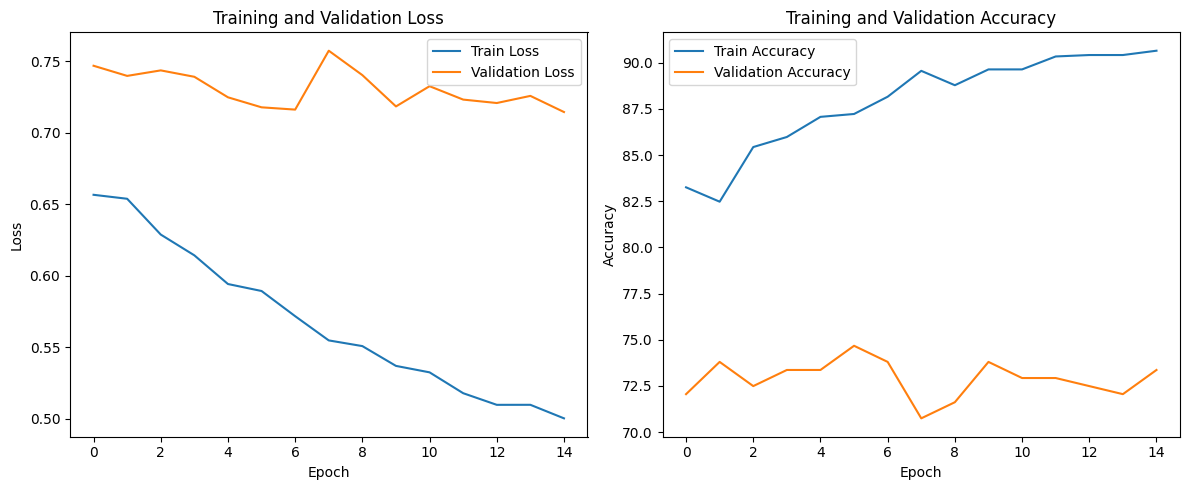

Average Test Loss: 0.6982
Test Accuracy: 76.24%


In [20]:
run(model,train_loader, valid_loader, test_loader, optimizer, model_path="Best_MSA_model.pth", device=device)

In [21]:
test_loss = evaluate(model, test_loader, device)

Average Test Loss: 0.6982
Test Accuracy: 76.24%
